In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)
np.set_printoptions(threshold=10, edgeitems=5)

In [2]:
tile_size = 64
overlap = 128
y_drop = 7430
threshold = 4000

random_pattern = True
# number of PEs compute in the same time
num_PE = 64

In [3]:
# W = {'A': {'A':  91, 'C': -90, 'G': -25, 'T':-100},
#      'C': {'A': -90, 'C': 100, 'G':-100, 'T': -25},
#      'G': {'A': -25, 'C':-100, 'G': 100, 'T': -90},
#      'T': {'A':-100, 'C': -25, 'G': -90, 'T':  91}}
# g_o = -430
# g_e = -30

W = {'A': {'A': 3, 'C':-3, 'G':-1, 'T':-4},
     'C': {'A':-3, 'C': 4, 'G':-4, 'T':-1},
     'G': {'A':-1, 'C':-4, 'G': 4, 'T':-3},
     'T': {'A':-4, 'C':-1, 'G':-3, 'T': 3}}
g_o = -12
g_e = -1

In [4]:
# W = {'A': {'A': 2, 'C':-3, 'G':-3, 'T':-3},
#      'C': {'A':-3, 'C': 2, 'G':-3, 'T':-3},
#      'G': {'A':-3, 'C':-3, 'G': 2, 'T':-3},
#      'T': {'A':-3, 'C':-3, 'G':-3, 'T': 2}}
# g_o = -7
# g_e = -2

In [5]:
f = open('sequence_1.txt', 'r')
gene_1 = ''
f.readline()
for line in f.readlines():
    gene_1 = gene_1 + line[:-1]
f.close()

f = open('sequence_2.txt', 'r')
gene_2 = ''
f.readline()
for line in f.readlines():
    gene_2 = gene_2 + line[:-1]
f.close()

print(len(gene_1), len(gene_2))

607 763


In [6]:
bias = 0
gene_1, gene_2 = gene_1[bias:bias+tile_size], gene_2[bias:bias+tile_size]
print(len(gene_1), len(gene_2))
print(gene_1)
print(gene_2)

64 64
ATGTTCTCTCGGAGGATGTATTATCTTTTGCTCATTCTAAGCACAATGCTTTCTTTCCACCTTG
ATGTTCTCTCGGAGGATTTATTATCTTTTGCTCATTTTAAGCACAATGCTTTCTTTTCACCTTG


In [7]:
import random
random.seed(10)

d = ['A', 'C', 'G', 'T']
if random_pattern:
    gene_1, gene_2 = '', ''
    for i in range(tile_size):
        gene_1 += d[random.randint(0, 3)]
    i = 0
    while i < tile_size:
        die = random.random()
        l = random.randint(1,8)
        # delete gene_1 for length l
        if die < 0.05:
            i += l
        # insert gene_1 for length l
        elif die < 0.1:
            for j in range(l):
                gene_2 += d[random.randint(0, 3)]
            i += 1
        # change 1 gene
        elif die < 0.15:
            gene_2 += d[random.randint(0, 3)]
            i += 1
        else:
            gene_2 += gene_1[i]
            i += 1
    while len(gene_2) < tile_size:
        gene_2 += d[random.randint(0, 3)]
            
    print(len(gene_1), len(gene_2))
    print(gene_1)
    print(gene_2)

64 88
ATTACTTGCATGACGATCGTTGGTCGGCTCTTAACCCGGCGTTTAGCCTCAATGAACTGCAATC
ATTAATTGCATGACGATCTTCTGTTCTTGGCACTGCTCTTCCCCGCTTCAGAGCCCCAAAGGGTTTGAACTGTCTAGAAGGCCCGATC


In [8]:
# tile_size = 52
# gene_1 = gene_1[:tile_size]
# gene_2 = gene_2[:tile_size]
# print(gene_1)
# print(gene_2)

# Normal version

In [9]:
# Score matrix
V = np.zeros((tile_size+1, tile_size+1))
I = np.zeros((tile_size+1, tile_size+1))
D = np.zeros((tile_size+1, tile_size+1))
for i in range(1, tile_size+1):
    V[0, i] = g_o + (i-1)*g_e
    V[i, 0] = g_o + (i-1)*g_e
    D[0, i] = float('-inf')
    D[i, 0] = g_o + (i-1)*g_e
    I[0, i] = g_o + (i-1)*g_e
    I[i, 0] = float('-inf')
print('Score matrix')
print(V)
print('Insertion matrix (Score when direction is left)')
print(I)
print('Deletion matrix (Score when direction is top)')
print(D)
# Direction matrix, 0:no compute, 1:top-left, 2:top, 3:left
Trace = np.zeros((tile_size+1, tile_size+1), dtype=int)
# When direction = 'left' or 'top', we needs to trace next direction on 'Trace_I' or 'Trace_D' instead of 'Trace'
# 0:from Trace_I or Trace_D (extend gap), 1:from Trace (new gap)
Trace_I = np.zeros((tile_size+1, tile_size+1), dtype=int)
Trace_D = np.zeros((tile_size+1, tile_size+1), dtype=int)

Score matrix
[[  0. -12. -13. -14. -15. ... -71. -72. -73. -74. -75.]
 [-12.   0.   0.   0.   0. ...   0.   0.   0.   0.   0.]
 [-13.   0.   0.   0.   0. ...   0.   0.   0.   0.   0.]
 [-14.   0.   0.   0.   0. ...   0.   0.   0.   0.   0.]
 [-15.   0.   0.   0.   0. ...   0.   0.   0.   0.   0.]
 ...
 [-71.   0.   0.   0.   0. ...   0.   0.   0.   0.   0.]
 [-72.   0.   0.   0.   0. ...   0.   0.   0.   0.   0.]
 [-73.   0.   0.   0.   0. ...   0.   0.   0.   0.   0.]
 [-74.   0.   0.   0.   0. ...   0.   0.   0.   0.   0.]
 [-75.   0.   0.   0.   0. ...   0.   0.   0.   0.   0.]]
Insertion matrix (Score when direction is left)
[[  0. -12. -13. -14. -15. ... -71. -72. -73. -74. -75.]
 [-inf   0.   0.   0.   0. ...   0.   0.   0.   0.   0.]
 [-inf   0.   0.   0.   0. ...   0.   0.   0.   0.   0.]
 [-inf   0.   0.   0.   0. ...   0.   0.   0.   0.   0.]
 [-inf   0.   0.   0.   0. ...   0.   0.   0.   0.   0.]
 ...
 [-inf   0.   0.   0.   0. ...   0.   0.   0.   0.   0.]
 [-inf   0.   0.

In [10]:
V_max = float('-inf')
x_max, y_max = 0, 0
i,j = 1,1
print(V[i-1][j-1] + W[gene_1[i-1]][gene_2[j-1]])
print(V[i][j-1]+g_o, I[i][j-1]+g_e)
print(V[i-1][j]+g_o, D[i-1][j]+g_e)

for i in range(1, tile_size+1):
    for j in range(1, tile_size+1):
        V_nxt = V[i-1][j-1] + W[gene_1[i-1]][gene_2[j-1]]
        I[i][j] = max(V[i][j-1]+g_o, I[i][j-1]+g_e)
        D[i][j] = max(V[i-1][j]+g_o, D[i-1][j]+g_e)
        V[i][j] = max(V_nxt, I[i][j], D[i][j])
        # if new maximum
        if V[i][j] >= V_max:
            V_max = V[i][j]
            x_max, y_max = i, j
        # direction of Trace
        if V[i][j] == V_nxt:
            Trace[i][j] = 1
        elif V[i][j] == D[i][j]:
            Trace[i][j] = 2
        elif V[i][j] == I[i][j]:
            Trace[i][j] = 3
        # direction of Trace_I
        if I[i][j] == V[i][j-1]+g_o:
            Trace_I[i][j] = 1
        else:
            Trace_I[i][j] = 0
        # direction of Trace_D
        if D[i][j] == V[i-1][j]+g_o:
            Trace_D[i][j] = 1
        else:
            Trace_D[i][j] = 0
    # print(V_max)
print('Score matrix')
print(V)
print('Insertion matrix (Score when direction is left)')
print(I)
print('Deletion matrix (Score when direction is top)')
print(D)
print('Direction')
print(Trace)
print('Direction of I')
print(Trace_D)
print('Direction of D')
print(Trace_I)
print(V_max, x_max, y_max)

3.0
-24.0 -inf
-24.0 -inf
Score matrix
[[  0. -12. -13. -14. -15. ... -71. -72. -73. -74. -75.]
 [-12.   3.  -9. -10. -11. ... -67. -68. -69. -70. -71.]
 [-13.  -9.   6.  -6.  -7. ... -63. -64. -65. -66. -67.]
 [-14. -10.  -6.   9.  -3. ... -59. -60. -61. -62. -63.]
 [-15. -11.  -7.  -3.  12. ... -55. -56. -57. -58. -59.]
 ...
 [-71. -67. -63. -59. -55. ...  50.  54.  54.  56.  59.]
 [-72. -68. -64. -60. -56. ...  61.  53.  53.  53.  53.]
 [-73. -69. -65. -61. -57. ...  56.  60.  54.  53.  52.]
 [-74. -70. -66. -62. -58. ...  64.  53.  57.  51.  56.]
 [-75. -71. -67. -63. -59. ...  53.  60.  50.  53.  50.]]
Insertion matrix (Score when direction is left)
[[  0. -12. -13. -14. -15. ... -71. -72. -73. -74. -75.]
 [-inf -24.  -9. -10. -11. ... -67. -68. -69. -70. -71.]
 [-inf -25. -21.  -6.  -7. ... -63. -64. -65. -66. -67.]
 [-inf -26. -22. -18.  -3. ... -59. -60. -61. -62. -63.]
 [-inf -27. -23. -19. -15. ... -55. -56. -57. -58. -59.]
 ...
 [-inf -83. -79. -75. -71. ...  48.  47.  46.  

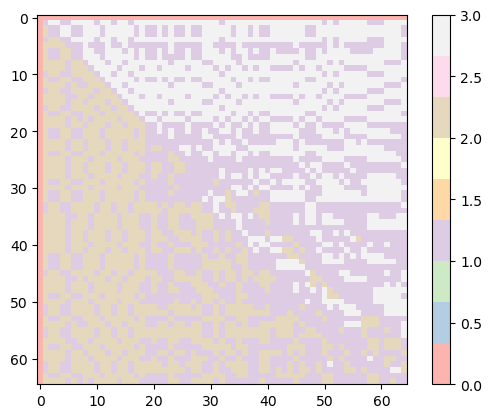

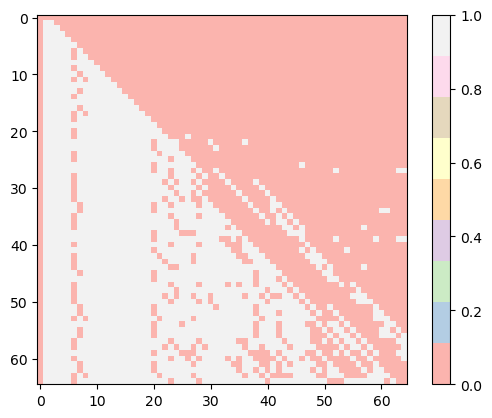

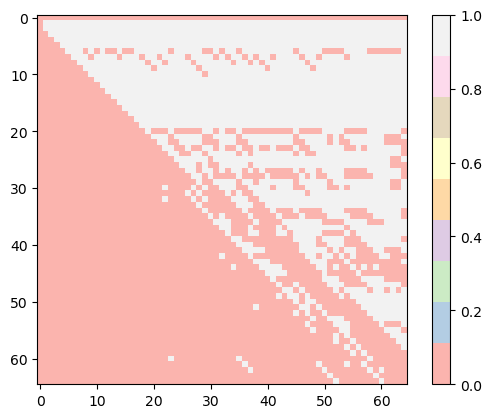

In [11]:
Trace_ans = Trace
Trace_I_ans = Trace_I
Trace_D_ans = Trace_D
plt.imshow(Trace[:, :], cmap='Pastel1')
plt.colorbar()
plt.show()
plt.imshow(Trace_I[:, :], cmap='Pastel1')
plt.colorbar()
plt.show()
plt.imshow(Trace_D[:, :], cmap='Pastel1')
plt.colorbar()
plt.show()

Score: 71.0, Position: (54, 61)


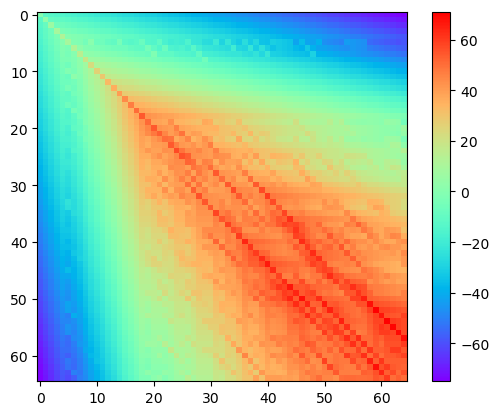

In [12]:
V_ans = V
print(f'Score: {V_max}, Position: {x_max, y_max}')
plt.imshow(V[:, :], cmap='rainbow')
plt.colorbar()
plt.show()

In [13]:
seq_1 = ''
seq_2 = ''
result = ''
# which matirx are we tracking now
target_matrix = 'T'

x, y = x_max, y_max
while(x != 0) and (y != 0):
    if target_matrix == 'T':
        # print('T', Trace[x][y], x, y)
        if Trace[x][y] == 1:
            seq_1 = gene_1[x-1] + seq_1
            seq_2 = gene_2[y-1] + seq_2
            if gene_1[x-1] == gene_2[y-1]:
                result = '|' + result
            else:
                result = ' ' + result
            x, y = x-1, y-1
        # if direction = top, move to Trace_D
        elif Trace[x][y] == 2:
            if Trace_D[x][y] == 0:
                target_matrix = 'D'
            seq_1 = gene_1[x-1] + seq_1
            seq_2 = '-' + seq_2
            result = ' ' + result
            x, y = x-1, y
        # if direction = left, move to Trace_I
        elif Trace[x][y] == 3:
            if Trace_I[x][y] == 0:
                target_matrix = 'I'
            seq_1 = '-' + seq_1
            seq_2 = gene_2[y-1] + seq_2
            result = ' ' + result
            x, y = x, y-1
    elif target_matrix == 'D':
        # print('D', Trace_D[x][y], x, y)
        # move to Trace if reach gap origin
        if Trace_D[x][y] == 1:
            target_matrix = 'T'
        seq_1 = gene_1[x-1] + seq_1
        seq_2 = '-' + seq_2
        result = ' ' + result
        x, y = x-1, y
    elif target_matrix == 'I':
        # print('I', Trace_I[x][y], x, y)
        # move to Trace if reach gap origin
        if Trace_I[x][y] == 1:
            target_matrix = 'T'
        seq_1 = '-' + seq_1
        seq_2 = gene_2[y-1] + seq_2
        result = ' ' + result
        x, y = x, y-1

width = 60
parts = len(seq_1)//width + 1
print(f'Score: {V_max}, Position: {x_max, y_max}')
for i in range(parts):
    print(seq_1[i*width:min(i*width+width, len(seq_1))])
    print(result[i*width:min(i*width+width, len(result))])
    print(seq_2[i*width:min(i*width+width, len(seq_2))])
    print('')

seq_1_ans = seq_1
seq_2_ans = seq_2
result_ans = result

Score: 71.0, Position: (54, 61)
ATTACTTGCATGACGATCGTTGGT--------CGGCTCTTAACCCGGCGTT-TAGCCTCA
|||| ||||||||||||| |  ||        | ||||||  ||| || |   |||| ||
ATTAATTGCATGACGATCTTCTGTTCTTGGCACTGCTCTT--CCCCGCTTCAGAGCCCCA

ATG
| |
AAG



In [14]:
# checking calculation
score = 0
for i in range(len(seq_1)):
    if seq_1[i] == '-':
        if seq_1[i-1] == '-':
            score += g_e
        else:
            score += g_o
    elif seq_2[i] == '-':
        if seq_2[i-1] == '-':
            score += g_e
        else:
            score += g_o
    else:
        score += W[seq_1[i]][seq_2[i]]
print(score)

71


# With stripe (No banded)

In [15]:
# Score matrix
V = np.zeros((tile_size+1, tile_size+1))
V = V + float('-inf')
V[0][0] = 0
I = np.zeros((tile_size+1, tile_size+1))
D = np.zeros((tile_size+1, tile_size+1))
for i in range(1, tile_size+1):
    V[0, i] = g_o + (i-1)*g_e
    V[i, 0] = g_o + (i-1)*g_e
    D[0, i] = float('-inf')
    D[i, 0] = g_o + (i-1)*g_e
    I[0, i] = g_o + (i-1)*g_e
    I[i, 0] = float('-inf')
print('Score matrix')
print(V)
print('Insertion matrix (Score when direction is left)')
print(I)
print('Deletion matrix (Score when direction is top)')
print(D)
# Direction matrix, 0:no compute, 1:top-left, 2:top, 3:left
Trace = np.zeros((tile_size+1, tile_size+1), dtype=int)
# When direction = 'left' or 'top', we needs to trace next direction on 'Trace_I' or 'Trace_D' instead of 'Trace'
# 0:from Trace_I or Trace_D (extend gap), 1:from Trace (new gap)
Trace_I = np.zeros((tile_size+1, tile_size+1), dtype=int)
Trace_D = np.zeros((tile_size+1, tile_size+1), dtype=int)

Score matrix
[[  0. -12. -13. -14. -15. ... -71. -72. -73. -74. -75.]
 [-12. -inf -inf -inf -inf ... -inf -inf -inf -inf -inf]
 [-13. -inf -inf -inf -inf ... -inf -inf -inf -inf -inf]
 [-14. -inf -inf -inf -inf ... -inf -inf -inf -inf -inf]
 [-15. -inf -inf -inf -inf ... -inf -inf -inf -inf -inf]
 ...
 [-71. -inf -inf -inf -inf ... -inf -inf -inf -inf -inf]
 [-72. -inf -inf -inf -inf ... -inf -inf -inf -inf -inf]
 [-73. -inf -inf -inf -inf ... -inf -inf -inf -inf -inf]
 [-74. -inf -inf -inf -inf ... -inf -inf -inf -inf -inf]
 [-75. -inf -inf -inf -inf ... -inf -inf -inf -inf -inf]]
Insertion matrix (Score when direction is left)
[[  0. -12. -13. -14. -15. ... -71. -72. -73. -74. -75.]
 [-inf   0.   0.   0.   0. ...   0.   0.   0.   0.   0.]
 [-inf   0.   0.   0.   0. ...   0.   0.   0.   0.   0.]
 [-inf   0.   0.   0.   0. ...   0.   0.   0.   0.   0.]
 [-inf   0.   0.   0.   0. ...   0.   0.   0.   0.   0.]
 ...
 [-inf   0.   0.   0.   0. ...   0.   0.   0.   0.   0.]
 [-inf   0.   0.

In [16]:
# start position of next PE stripe
column_start_nxt = 1
V_max = 0
x_max, y_max = 0, 0
# 4 PEs compute in the same time
for i in range(1, tile_size+1, 4):
    column_start_nxt_determined = False
    # column = column_start_nxt # current row
    column = 1
    stripe_end = False
    while not stripe_end:
        # row index: i+j, column index:column
        for j in range(4):
            # print(i+j, column)
            V_nxt = V[i+j-1][column-1] + W[gene_1[i+j-1]][gene_2[column-1]]
            I[i+j][column] = max(V[i+j][column-1]+g_o, I[i+j][column-1]+g_e)
            D[i+j][column] = max(V[i+j-1][column]+g_o, D[i+j-1][column]+g_e)
            V[i+j][column] = max(V_nxt, I[i+j][column], D[i+j][column])
            # print(i+j, column, V[i+j][column])
            # track max score
            if V[i+j][column] >= V_max:
                V_max = V[i+j][column]
                x_max, y_max = i+j, column
            # track direction
            if V[i+j][column] == V_nxt:
                Trace[i+j][column] = 1
            elif V[i+j][column] == D[i+j][column]:
                Trace[i+j][column] = 2
            elif V[i+j][column] == I[i+j][column]:
                Trace[i+j][column] = 3
            # direction of Trace_I
            if I[i+j][column] == V[i+j][column-1]+g_o:
                Trace_I[i+j][column] = 1
            else:
                Trace_I[i+j][column] = 0
            # direction of Trace_D
            if D[i+j][column] == V[i+j-1][column]+g_o:
                Trace_D[i+j][column] = 1
            else:
                Trace_D[i+j][column] = 0
            
        # if stripe end
        if column == tile_size:
            stripe_end = True
        '''
        elif (V[i][column]<V_max-y_drop) & (V[i+1][column]<V_max-y_drop) & (V[i+2][column]<V_max-y_drop) & (V[i+3][column]<V_max-y_drop):
            stripe_end = True
        '''
        # next stripe start position
        if not column_start_nxt_determined:
            if (V[i][column]>V_max-y_drop) & (V[i+1][column]>V_max-y_drop) & (V[i+2][column]>V_max-y_drop) & (V[i+3][column]>V_max-y_drop):
                column_start_nxt = column
                column_start_nxt_determined =True
        # PE shift to next column
        column += 1

print('Score matrix')
print(V)
print('Insertion matrix (Score when direction is left)')
print(I)
print('Deletion matrix (Score when direction is top)')
print(D)
print('Direction')
print(Trace)
print(V_max, x_max, y_max)

Score matrix
[[  0. -12. -13. -14. -15. ... -71. -72. -73. -74. -75.]
 [-12.   3.  -9. -10. -11. ... -67. -68. -69. -70. -71.]
 [-13.  -9.   6.  -6.  -7. ... -63. -64. -65. -66. -67.]
 [-14. -10.  -6.   9.  -3. ... -59. -60. -61. -62. -63.]
 [-15. -11.  -7.  -3.  12. ... -55. -56. -57. -58. -59.]
 ...
 [-71. -67. -63. -59. -55. ...  50.  54.  54.  56.  59.]
 [-72. -68. -64. -60. -56. ...  61.  53.  53.  53.  53.]
 [-73. -69. -65. -61. -57. ...  56.  60.  54.  53.  52.]
 [-74. -70. -66. -62. -58. ...  64.  53.  57.  51.  56.]
 [-75. -71. -67. -63. -59. ...  53.  60.  50.  53.  50.]]
Insertion matrix (Score when direction is left)
[[  0. -12. -13. -14. -15. ... -71. -72. -73. -74. -75.]
 [-inf -24.  -9. -10. -11. ... -67. -68. -69. -70. -71.]
 [-inf -25. -21.  -6.  -7. ... -63. -64. -65. -66. -67.]
 [-inf -26. -22. -18.  -3. ... -59. -60. -61. -62. -63.]
 [-inf -27. -23. -19. -15. ... -55. -56. -57. -58. -59.]
 ...
 [-inf -83. -79. -75. -71. ...  48.  47.  46.  45.  44.]
 [-inf -84. -80.

In [17]:
print(Trace_ans.all() == Trace.all())
print(Trace_I_ans.all() == Trace_I.all())
print(Trace_D_ans.all() == Trace_D.all())
print(V_ans.all() == V.all())

True
True
True
True


54 61


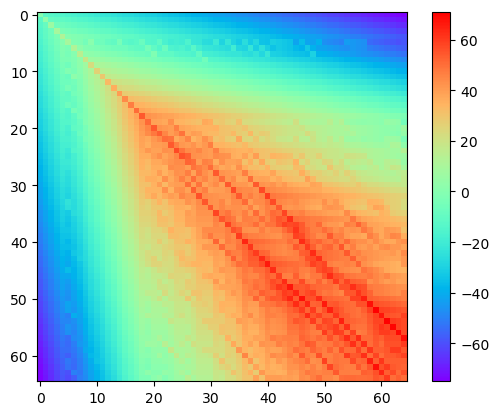

In [18]:
print(x_max, y_max)
plt.imshow(V[:, :], cmap='rainbow')
plt.colorbar()
plt.show()

# With stripe (banded)

In [19]:
# Score matrix
V = np.zeros((tile_size+1, tile_size+1))
V = V + float('-inf')
V[0][0] = 0
I = np.zeros((tile_size+1, tile_size+1))
I = I + float('-inf')
I[0][0] = 0
D = np.zeros((tile_size+1, tile_size+1))
D = D + float('-inf')
D[0][0] = 0

for i in range(1, tile_size+1):
    V[0, i] = g_o + (i-1)*g_e
    V[i, 0] = g_o + (i-1)*g_e
    D[0, i] = float('-inf')
    D[i, 0] = g_o + i*g_e
    I[0, i] = g_o + i*g_e
    I[i, 0] = float('-inf')
print('Score matrix')
print(V)
print('Insertion matrix (Score when direction is left)')
print(I)
print('Deletion matrix (Score when direction is top)')
print(D)
# Direction matrix, 0:no compute, 1:top-left, 2:top, 3:left
Trace = np.zeros((tile_size+1, tile_size+1), dtype=int)
# When direction = 'left' or 'top', we needs to trace next direction on 'Trace_I' or 'Trace_D' instead of 'Trace'
# 0:from Trace_I or Trace_D (extend gap), 1:from Trace (new gap)
Trace_I = np.zeros((tile_size+1, tile_size+1), dtype=int)
Trace_D = np.zeros((tile_size+1, tile_size+1), dtype=int)

Score matrix
[[  0. -12. -13. -14. -15. ... -71. -72. -73. -74. -75.]
 [-12. -inf -inf -inf -inf ... -inf -inf -inf -inf -inf]
 [-13. -inf -inf -inf -inf ... -inf -inf -inf -inf -inf]
 [-14. -inf -inf -inf -inf ... -inf -inf -inf -inf -inf]
 [-15. -inf -inf -inf -inf ... -inf -inf -inf -inf -inf]
 ...
 [-71. -inf -inf -inf -inf ... -inf -inf -inf -inf -inf]
 [-72. -inf -inf -inf -inf ... -inf -inf -inf -inf -inf]
 [-73. -inf -inf -inf -inf ... -inf -inf -inf -inf -inf]
 [-74. -inf -inf -inf -inf ... -inf -inf -inf -inf -inf]
 [-75. -inf -inf -inf -inf ... -inf -inf -inf -inf -inf]]
Insertion matrix (Score when direction is left)
[[  0. -13. -14. -15. -16. ... -72. -73. -74. -75. -76.]
 [-inf -inf -inf -inf -inf ... -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf ... -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf ... -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf ... -inf -inf -inf -inf -inf]
 ...
 [-inf -inf -inf -inf -inf ... -inf -inf -inf -inf -inf]
 [-inf -inf -inf

In [20]:
# start position of next PE stripe
column_start = 1
column_end = 1
V_max = 0
V_max_local = 0
x_max, y_max = 0, 0
x_max_local, y_max_local = 0, 0

for i in range(1, tile_size+1, num_PE):
    column = column_start # current row
    V_max_local = 0
    # print(f"{(i+3)//4}'th stripe start at column {column}")
    stripe_end = False
    while not stripe_end:
        # row index: i+j, column index:column
        for j in range(num_PE):
            if i+j > tile_size:
                break
            # print(i+j, column)
            V_nxt = V[i+j-1][column-1] + W[gene_1[i+j-1]][gene_2[column-1]]
            I[i+j][column] = max(V[i+j][column-1]+g_o, I[i+j][column-1]+g_e)
            D[i+j][column] = max(V[i+j-1][column]+g_o, D[i+j-1][column]+g_e)
            V[i+j][column] = max(V_nxt, I[i+j][column], D[i+j][column])
            # print(i+j, column, V[i+j][column])
            # track max score
            if V[i+j][column] >= V_max:
                V_max = V[i+j][column]
                x_max, y_max = i+j, column
            # local minimum for stripe end
            if V[i+j][column] >= V_max_local:
                V_max_local = V[i+j][column]
                x_max_local, y_max_local = i+j, column
            # track direction
            if V[i+j][column] == V_nxt:
                Trace[i+j][column] = 1
            elif V[i+j][column] == D[i+j][column]:
                Trace[i+j][column] = 2
            elif V[i+j][column] == I[i+j][column]:
                Trace[i+j][column] = 3
            # direction of Trace_I
            if I[i+j][column] == V[i+j][column-1]+g_o:
                Trace_I[i+j][column] = 1
            else:
                Trace_I[i+j][column] = 0
            # direction of Trace_D
            if D[i+j][column] == V[i+j-1][column]+g_o:
                Trace_D[i+j][column] = 1
            else:
                Trace_D[i+j][column] = 0
        # if stripe end
        # working number of PEs amy < total number when last stripe
        PEs = min(num_PE, tile_size-i+1)
        max_in_PEs = max([V[i+j][column] for j in range(PEs)])
        # print(max_in_PEs, V_max, V_max-y_drop)
        # needs to end far than max_y
        if column < column_end:
            pass
        elif column == tile_size:
            stripe_end = True
            column_end = column
            # print(f"{(i+3)//4}'th stripe ended at column {column}")
        elif (max_in_PEs < V_max_local-y_drop):
            stripe_end = True
            column_end = column
            # print(f"{(i+3)//4}'th stripe ended at column {column}")
        # PE shift to next column
        column += 1
    # next stripe start position
    column_start_old = column_start
    min_in_PEs = min([V[i+j][column_start] for j in range(PEs)])
    early_end = False
    while min_in_PEs < V_max_local-y_drop:
        column_start += 1
        if column_start > tile_size:
            early_end = True
            break
        min_in_PEs = min([V[i+j][column_start] for j in range(PEs)])
        # print('find next start:', i, column_start, V_max_local-y_drop, min_in_PEs)
    print(V_max, V_max_local, column_start)
    # all score in stripe < maximum
    if early_end:
        break
print('Score matrix')
print(V)
print('Insertion matrix (Score when direction is left)')
print(I)
print('Deletion matrix (Score when direction is top)')
print(D)
print('Direction')
print(Trace)
print(V_max, x_max, y_max)

71.0 71.0 1
Score matrix
[[  0. -12. -13. -14. -15. ... -71. -72. -73. -74. -75.]
 [-12.   3.  -9. -10. -11. ... -67. -68. -69. -70. -71.]
 [-13.  -9.   6.  -6.  -7. ... -63. -64. -65. -66. -67.]
 [-14. -10.  -6.   9.  -3. ... -59. -60. -61. -62. -63.]
 [-15. -11.  -7.  -3.  12. ... -55. -56. -57. -58. -59.]
 ...
 [-71. -67. -63. -59. -55. ...  50.  54.  54.  56.  59.]
 [-72. -68. -64. -60. -56. ...  61.  53.  53.  53.  53.]
 [-73. -69. -65. -61. -57. ...  56.  60.  54.  53.  52.]
 [-74. -70. -66. -62. -58. ...  64.  53.  57.  51.  56.]
 [-75. -71. -67. -63. -59. ...  53.  60.  50.  53.  50.]]
Insertion matrix (Score when direction is left)
[[  0. -13. -14. -15. -16. ... -72. -73. -74. -75. -76.]
 [-inf -24.  -9. -10. -11. ... -67. -68. -69. -70. -71.]
 [-inf -25. -21.  -6.  -7. ... -63. -64. -65. -66. -67.]
 [-inf -26. -22. -18.  -3. ... -59. -60. -61. -62. -63.]
 [-inf -27. -23. -19. -15. ... -55. -56. -57. -58. -59.]
 ...
 [-inf -83. -79. -75. -71. ...  48.  47.  46.  45.  44.]
 [-i

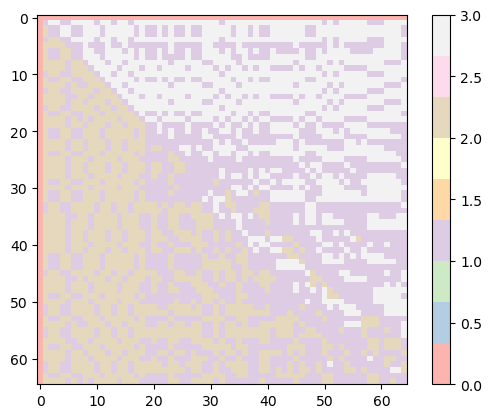

In [21]:
plt.imshow(Trace[:, :], cmap='Pastel1')
plt.colorbar()
plt.show()

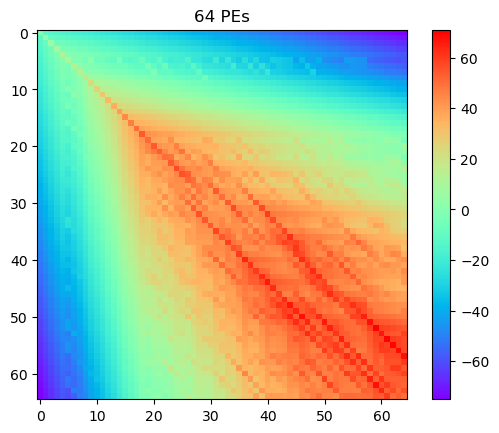

Score: 71.0 Position: (54, 61)
Local Max: 71.0 Position: (54, 61)


In [22]:
plt.imshow(V[:, :], cmap='rainbow')
plt.colorbar()
plt.title(f'{num_PE} PEs')
plt.show()
print('Score:', V_max, f'Position: {x_max, y_max}')
print('Local Max:', V_max_local, f'Position: {x_max_local, y_max_local}')

In [23]:
seq_1 = ''
seq_2 = ''
result = ''
# which matirx are we tracking now
target_matrix = 'T'

x, y = x_max, y_max
while(x != 0) and (y != 0):
    if target_matrix == 'T':
        # print('T', Trace[x][y], x, y)
        if Trace[x][y] == 1:
            seq_1 = gene_1[x-1] + seq_1
            seq_2 = gene_2[y-1] + seq_2
            if gene_1[x-1] == gene_2[y-1]:
                result = '|' + result
            else:
                result = ' ' + result
            x, y = x-1, y-1
        # if direction = top, move to Trace_D
        elif Trace[x][y] == 2:
            if Trace_D[x][y] == 0:
                target_matrix = 'D'
            seq_1 = gene_1[x-1] + seq_1
            seq_2 = '-' + seq_2
            result = ' ' + result
            x, y = x-1, y
        # if direction = left, move to Trace_I
        elif Trace[x][y] == 3:
            if Trace_I[x][y] == 0:
                target_matrix = 'I'
            seq_1 = '-' + seq_1
            seq_2 = gene_2[y-1] + seq_2
            result = ' ' + result
            x, y = x, y-1
    elif target_matrix == 'D':
        # print('D', Trace_D[x][y], x, y)
        # move to Trace if reach gap origin
        if Trace_D[x][y] == 1:
            target_matrix = 'T'
        seq_1 = gene_1[x-1] + seq_1
        seq_2 = '-' + seq_2
        result = ' ' + result
        x, y = x-1, y
    elif target_matrix == 'I':
        # print('I', Trace_I[x][y], x, y)
        # move to Trace if reach gap origin
        if Trace_I[x][y] == 1:
            target_matrix = 'T'
        seq_1 = '-' + seq_1
        seq_2 = gene_2[y-1] + seq_2
        result = ' ' + result
        x, y = x, y-1

parts = len(seq_1)//width + 1
for i in range(parts):
    print(seq_1[i*width:min(i*width+width, len(seq_1))])
    print(result[i*width:min(i*width+width, len(result))])
    print(seq_2[i*width:min(i*width+width, len(seq_2))])
    print('')

print(seq_1 == seq_1_ans)
print(seq_2 == seq_2_ans)

ATTACTTGCATGACGATCGTTGGT--------CGGCTCTTAACCCGGCGTT-TAGCCTCA
|||| ||||||||||||| |  ||        | ||||||  ||| || |   |||| ||
ATTAATTGCATGACGATCTTCTGTTCTTGGCACTGCTCTT--CCCCGCTTCAGAGCCCCA

ATG
| |
AAG

True
True


In [24]:
f1 = open('./verilog/gene_1_array.txt', 'w')
f2 = open('./verilog/gene_2_array.txt', 'w')
d = {'A':0, 'C':1, 'G':2, 'T':3}

for i in range(tile_size):
    f1.write(f'{d[gene_1[i]]}\n')
    f2.write(f'{d[gene_2[i]]}\n')

f1.close()
f2.close()